In [1]:
import requests
import csv 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pprint import pprint as pp

In [2]:
def call_census(endpoint_ext):
    '''
    Call census api for American Community Survey (ACS) Year=2019 and Data Profiles tables
    Returns JSON format results
    '''
    races = 'DP05_0037E,DP05_0038E,DP05_0039E,DP05_0044E,DP05_0052E,DP05_0057E,DP05_0071E'
    root = 'https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,'
    url = root + races + endpoint_ext
    response = requests.get(url)
    #print(url)
    #print(response)
    if (int(response.status_code)==200):
        #print('response',response.text)
        return response.text
    else:
        raise Exception("Non 200 status code") 

In [3]:
def get_population(state_num):
    '''
    builds variable for all counties within the selected state 
    Returns JSON format results
    '''
    county_state = '&for=county:003,077&in=state:' + state_num
    raw_response = call_census(county_state)
    #json_response = json.loads(raw_response)
    return raw_response

In [4]:
def lists_from_dictionary(values):
    #create two lists from each dictionary entry
    
    list1 = values[0]
    list2 = values[1]
    len1 = len(list1)
    len2 = len(list2)
    pop_var = []
    ret_list1 = []
    ret_list2 = []
    #print('values1',list1)
    #print('len1',len1)
    #print('values2',list2)
    
    for x in range(len1):
        item = list1[x]
        #print('item',x,item)
        #print('item[0]',item[0])
        pop_var.append(item[0])
        ret_list1.append(item[1]) 
        #print('pop_var',pop_var)
        
    for x in range(len2):
        #print('x2',x)
        item = list2[x]
        ret_list2.append(item[1]) 
        
    per_list1 = []  
    total1 = sum(ret_list1)
    #print('total1', total1)
    for x in range(len1):
        item = ret_list1[x]
        #print('item',x,item)
        percent = round(((item /total1)*100), 2)
        per_list1.append(percent)    
    
    per_list2 = []  
    total2 = sum(ret_list2)
    #print('total2', total2)
    for x in range(len2):
        item = ret_list2[x]
        #print('item',x,item)
        percent = round(((item /total2)*100), 2)
        per_list2.append(percent)
        
    #print('per_list1',per_list1)
    #print('per_list2',per_list2)
    #print('ret_list2',ret_list2)
    return pop_var, per_list1, per_list2

In [5]:
def values_for_graph(json_file):
    '''
    creates dictionary from census data
    creates values for graph
    '''
    census_dict = {}
    
    census_data = json.loads(json_file)
       
    names_list = []
    for x, row in enumerate(census_data):
        #print('row_data',row)
        row_len = len(row)
        census_list = []
        
        for y, column in enumerate(row):
            # use county name as dictionary key  
            if x == 0:
                #save population variable names
                if y <(row_len-2):
                    names_list.append(row[y]) 
            if x > 0:
                #print('names_list',names_list)
                #use first word as key
                cnty_words = row[0].split()
                census_dict_key = cnty_words[0]
                #print('key',census_dict_key)
                # build list of [variable_name,population_value], ignore last two columns    
                if y > 0 and y <(row_len-2):
                    if row[y]== '-999999999':
                        row[y] = '0'
                    census_list.append([names_list[y],int(row[y])])
        if x > 0:            
            #print('census_list',census_list)        
            census_dict[census_dict_key] = census_list                        
                 
    #print('header',header_list)
    
#create values for graphs
    legend_names = list(census_dict.keys())
    #print('legends',legend_names)
    values = list(census_dict.values())
    #print('values', values)
    pop_variables, bar1_list, bar2_list = lists_from_dictionary(values)
    
    #print('bar1_list',bar1_list)
    #print('bar2_list',bar2_list)
    
        
    variables_names = ['DP05_0037E','DP05_0038E','DP05_0039E','DP05_0044E','DP05_0052E','DP05_0057E','DP05_0071E']
    pop_variables_names = ['white','black','native amer', 'asian', 'pacific is', 'other','hispanic']
    zipped = zip(variables_names,pop_variables_names)
    lookup_list = list(zipped)
    #print('lookup_list',lookup_list)   
    
    #lookup population name from lookup_list
    len3 = len(lookup_list)
    names = []
    for x in range(len3):
        #print('x3',x)
        item = lookup_list[x]
        names.append(item[1])
   
    y_pos = np.arange(len(pop_variables))
    #print('y_pos',y_pos)
    #print('names',names)
    return legend_names, names, bar1_list, bar2_list, y_pos

In [6]:
def graph_two_counties(l_names, x_names, l_bar1, l_bar2, y_pos):
    #print('l_bar1',l_bar1)
    #print('l_bar2',l_bar2)
#graph total calls vs redacted calls
    width=0.3
    legend = l_names
    bar1 = plt.bar(y_pos, l_bar1, width=width)
    bar2 = plt.bar(y_pos+ width, l_bar2, width=width)
    plt.grid(color='black', linestyle='--', linewidth=2, axis='y', alpha=0.7)
    plt.xticks(y_pos, x_names)
    plt.ylabel('Percentage')
    plt.title('Population makeup for the requested counties')
    #loc=0 is best position as determined by matplotlib
    #i think loc=6 is better
    plt.legend(legend,loc=0)
    #add text to top of bar
    for bar in bar1 + bar2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height,
                 f'{height:,.0f}',
                 ha='center',
                 va='bottom')
    plt.show()    

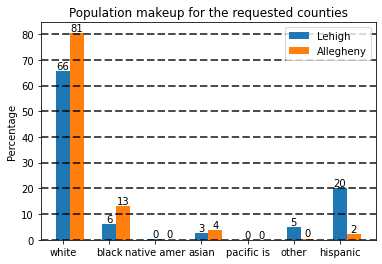

In [7]:
#get census data for Pennsylvania -state code=42
census_data = get_population('42')
#https://api.census.gov/data/2019/acs/acs1/spp?get=NAME,S0201_001E&for=state:*
#response = requests.get(url)
#print(census_data)
legend_names, names, bar1_list, bar2_list, y_pos = values_for_graph(census_data)
#print('bar1_list',bar1_list)
#print('bar2_list',bar2_list)
graph_two_counties(legend_names, names, bar1_list, bar2_list, y_pos)

In [8]:
'''
#https://api.census.gov/data/2019/acs/acs1/spp?get=NAME,S0201_001E&for=congressional%20district:01&in=state:01
#https://api.census.gov/data/2019/acs/acs1/spp?get=NAME,S0201_001E&for=county:085&in=state:06
#POPGROUP
#https://api.census.gov/data/2019/acs/acs1/spp/variables/POPGROUP.json
url = 'https://api.census.gov/data/2010/acs/acs1/spp?get=NAME,S0201_001E&for=congressional%20district:*&in=state:42'
url2 = 'https://api.census.gov/data/2010/acs/acs1/spp?get=NAME,S0201_001E&for=popgroup:*&for=congressional%20district:*&in=state:42'
url3 = 'https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=state:42'
url4 = 'https://api.census.gov/data/2019/acs/acs1?get=name,B02003_001E&for=state:42'
url5 = 'https://api.census.gov/data/2019/acs/acs1?get=NAME,B02003_001E&for=county:*&in=state:42'
url6 = 'https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,DP05_0033E,DP05_0070E,DP05_0070PE&for=county:*&in=state:42'
url7 = 'https://api.census.gov/data/2019/acs/acs5/profile?get=NAME,DP05_0033E,DP05_0070PE&for=county:*&in=state:42'
races = 'DP05_0033E,DP05_0037E,DP05_0038E,DP05_0039E,DP05_0044E,DP05_0052E,DP05_0057E,DP05_0070E,DP05_0071E,DP05_0071PE'
root = 'https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,'
county_state = '&for=county:*&in=state:42'
#https://api.census.gov/data/2019/pep/charagegroups?get=NAME
url = root + races + county_state
print(url)

response = requests.get(url)
print(response)
print(response.text)
json_data = json.loads(response.text)
print(json_data)
'''

"\n#https://api.census.gov/data/2019/acs/acs1/spp?get=NAME,S0201_001E&for=congressional%20district:01&in=state:01\n#https://api.census.gov/data/2019/acs/acs1/spp?get=NAME,S0201_001E&for=county:085&in=state:06\n#POPGROUP\n#https://api.census.gov/data/2019/acs/acs1/spp/variables/POPGROUP.json\nurl = 'https://api.census.gov/data/2010/acs/acs1/spp?get=NAME,S0201_001E&for=congressional%20district:*&in=state:42'\nurl2 = 'https://api.census.gov/data/2010/acs/acs1/spp?get=NAME,S0201_001E&for=popgroup:*&for=congressional%20district:*&in=state:42'\nurl3 = 'https://api.census.gov/data/2019/pep/charagegroups?get=NAME,POP&for=state:42'\nurl4 = 'https://api.census.gov/data/2019/acs/acs1?get=name,B02003_001E&for=state:42'\nurl5 = 'https://api.census.gov/data/2019/acs/acs1?get=NAME,B02003_001E&for=county:*&in=state:42'\nurl6 = 'https://api.census.gov/data/2019/acs/acs1/profile?get=NAME,DP05_0033E,DP05_0070E,DP05_0070PE&for=county:*&in=state:42'\nurl7 = 'https://api.census.gov/data/2019/acs/acs5/profil